In [253]:
# Stock Price Predictiong Using Python & Machine Learning with LSTM model (Long Short Term Memory)

In [254]:
# import libraries
import math                                    # mathematical functions        https://docs.python.org/3/library/math.html
import pandas_datareader as web                # data reader for panda         https://pandas-datareader.readthedocs.io/en/latest/
import numpy as np                             # numerical data in python      https://numpy.org/doc/stable/user/absolute_beginners.html
import pandas as pd                            # data analysis toolkit         https://pandas.pydata.org/pandas-docs/stable/user_guide/10min.html
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt                # plotting data in figures      https://matplotlib.org/2.0.2/users/pyplot_tutorial.html
from sklearn.preprocessing import MinMaxScaler # raw data utility functions    https://scikit-learn.org/stable/modules/preprocessing.html
from keras import metrics as metrics
import tensorflow as tf
import sqlite3
import os
from keras.models import Sequential            # input output sequence of data https://www.tensorflow.org/guide/keras/sequential_model
from datetime import datetime, timedelta       # for manipulating dates        https://docs.python.org/3/library/datetime.html
from keras.layers import Dense, LSTM, Dropout  # layers for neural network     https://keras.io/api/layers/
plt.style.use('fivethirtyeight')               # plot style                    https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

In [255]:
# Stock attributes
stock = 'RBLX'
source = 'yahoo'
today = datetime.now() # todays date (YYYY-MM-DD HH:MM:SS)
years = 20            # years back to start from when grabbing stocks, i.e 10 years = 2020-10 = 2010
startYear = today-timedelta(days=365*years)

# Get stock data using pandas data reader
df = web.DataReader(stock, data_source=source, start=startYear, end=today)

df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-03-10,74.830002,60.500000,64.500000,69.500000,97069300,69.500000
2021-03-11,77.779999,70.129997,74.930000,73.900002,59629300,73.900002
2021-03-12,72.959999,69.110001,72.470001,69.699997,19714700,69.699997
2021-03-15,74.059998,66.250000,70.019997,72.150002,19549800,72.150002
2021-03-16,78.000000,73.180000,73.730003,77.000000,30274400,77.000000
...,...,...,...,...,...,...
2021-11-24,126.000000,115.809998,116.680000,124.230003,28221200,124.230003
2021-11-26,131.000000,120.239998,129.500000,122.650002,11288400,122.650002
2021-11-29,129.899994,121.050003,125.137001,129.360001,17703000,129.360001


In [256]:
# Get rows and columns from the dataframe
df.shape

(186, 6)

Text(0, 0.5, 'Close Price USD ($)')

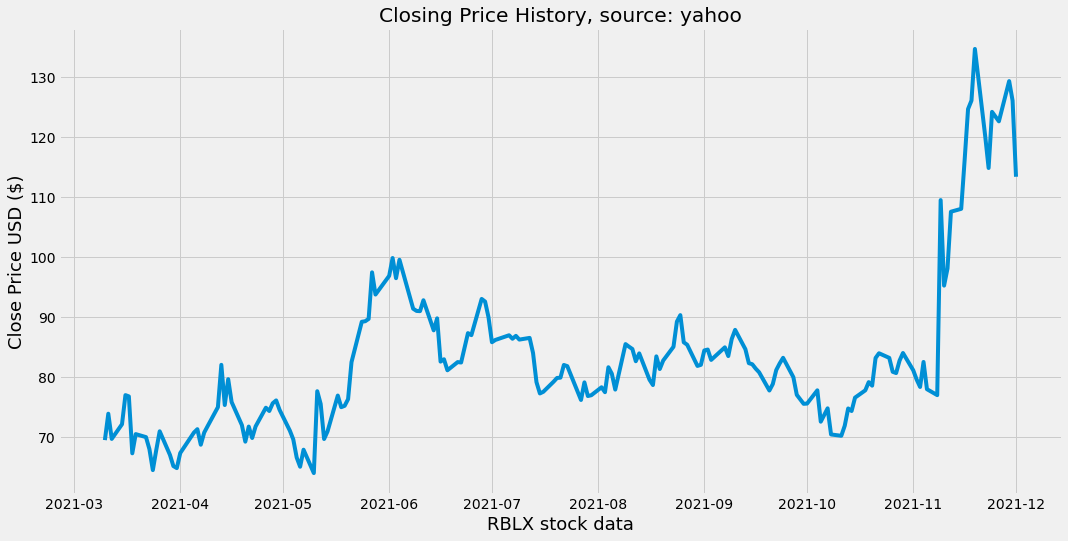

In [257]:
# Show closing price history
plt.figure(figsize=(16,8))
plt.title('Closing Price History, source: ' + source)
plt.plot(df['Close'])
plt.xlabel(stock + ' stock data', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)

In [258]:
# Create new dataframe with 'Close' column
data_target = df.filter(['Close'])

# Covert dataframe into a numpy array with a 1 day delay
dataset = data_target.shift(-1, fill_value=0).values

# Get the number of rows to train the model on, using 80% of the data
training_data_len = math.ceil(len(dataset) * .8)

# Scale data between 0 and 1 to avoid the bias using normalization
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.54854514],
       [0.51736933],
       [0.53555523],
       [0.57155581],
       [0.56999703],
       [0.49955465],
       [0.5233076 ],
       [0.51959619],
       [0.50475059],
       [0.47877078],
       [0.50363716],
       [0.52679632],
       [0.49755046],
       [0.48374404],
       [0.48122032],
       [0.49985151],
       [0.52523754],
       [0.52939429],
       [0.51016926],
       [0.52523754],
       [0.53317994],
       [0.55671021],
       [0.60904099],
       [0.55930818],
       [0.5913005 ],
       [0.56301958],
       [0.5344418 ],
       [0.51395485],
       [0.53266034],
       [0.51848276],
       [0.53280877],
       [0.55596794],
       [0.55188538],
       [0.5614608 ],
       [0.56502377],
       [0.55336997],
       [0.52761284],
       [0.51677555],
       [0.49428441],
       [0.48292753],
       [0.50400832],
       [0.47505938],
       [0.57638065],
       [0.56064429],
       [0.5172209 ],
       [0.52664783],
       [0.57103622],
       [0.556

In [259]:
# Create training dataset
# Create the scaled training dataset
train_data = scaled_data[0:training_data_len , :]

# Split data into x_train and y_train datasets
time_interval = int(len(dataset)*0.05) # amount of steps to train on, I.E the amount of data the LSTM uses per "step" ex: [0,1,2....60] if time_interval = 10 first LSTM step will be 0-9 and predict 10, second step woule be 1-10 and predict 11. =
x_train = []   # past x days, using previous example this would be 0-9
y_train = []   # predicted target value.              this would be predicted value for 10

# loop for the last x days
for i in range(time_interval, len(train_data)):
    x_train.append(train_data[i-time_interval:i, 0]) # append closingprice for i day
    y_train.append(train_data[i, 0])             # append predicted value
    
# Convert x_train and y_train to numpy arrays to use in LSTM model
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape data from 2D to 3D
# LSTM network needs 3D input (number of samples, timesteps and features)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(140, 9, 1)

In [260]:
# Build LSTM model
model = Sequential()

# # Run first layer with train data as input, 250 nodes, drop 20% when done, only return last output
# model.add(LSTM(250, return_sequences=True, input_shape=(x_train.shape[1], 1)))
# model.add(Dropout(0.2))

# # Run a second layer with 250 nodes, drop 10% 
# model.add(LSTM(250, return_sequences=True))
# model.add(Dropout(0.1))

# Run a third layer with 50 nodes, drop 10% when done return whole output
model.add(LSTM(500, return_sequences=False))
model.add(Dropout(0.1))

# Run a fourth layer with 25 nodes and 10% dropout
model.add(Dense(25))
model.add(Dropout(0.1))

model.add(Dense(units = 1))


In [261]:
# Method for calculating RMSE used for loss in model.compile
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [262]:
# Compile model
# Optimizer is to improve upon the loss function https://keras.io/api/optimizers/adam/
# loss function is used to measure how good the model did on training in terms of RMSE
# Metrics is used to evaluate the accuracy of predicitons (currently does not work)
model.compile(optimizer='adam', loss=root_mean_squared_error, metrics=[
        metrics.MeanSquaredError(name="MSE"),
        metrics.MeanAbsoluteError(name="MAE"),
        metrics.MeanSquaredLogarithmicError(name="MSLE")
    ]
)

In [263]:
# Train model
# Batch size is the total number of training examples present in a single batch.
# Epoch is the number of iterations when an entire dataset is passed forward and backward through a neural network
model.fit(x_train, y_train, batch_size=48, epochs=10)

Epoch 1/10
3/3 [==============================] - 1s 27ms/step - loss: 0.3360 - MSE: 0.1535 - MAE: 0.3290 - MSLE: 0.0871
Epoch 2/10
3/3 [==============================] - 0s 42ms/step - loss: 0.1008 - MSE: 0.0111 - MAE: 0.0840 - MSLE: 0.0043
Epoch 3/10
3/3 [==============================] - 0s 35ms/step - loss: 0.0766 - MSE: 0.0060 - MAE: 0.0623 - MSLE: 0.0024
Epoch 4/10
3/3 [==============================] - 0s 27ms/step - loss: 0.0786 - MSE: 0.0065 - MAE: 0.0667 - MSLE: 0.0025
Epoch 5/10
3/3 [==============================] - 0s 27ms/step - loss: 0.0739 - MSE: 0.0056 - MAE: 0.0595 - MSLE: 0.0023
Epoch 6/10
3/3 [==============================] - 0s 27ms/step - loss: 0.0706 - MSE: 0.0051 - MAE: 0.0586 - MSLE: 0.0019
Epoch 7/10
3/3 [==============================] - 0s 27ms/step - loss: 0.0535 - MSE: 0.0029 - MAE: 0.0421 - MSLE: 0.0012
Epoch 8/10
3/3 [==============================] - 0s 27ms/step - loss: 0.0627 - MSE: 0.0040 - MAE: 0.0502 - MSLE: 0.0016
Epoch 9/10
3/3 [================

In [264]:
# Create testing dataset
# Create a new array containing scaled values
test_data = scaled_data[training_data_len - time_interval: :]

# Create the data sets x_test and y_test
x_test = [] # past x days
y_test = dataset[training_data_len:, :] # predicted value

# loop for the last x days
for i in range(time_interval, len(test_data)):
    x_test.append(test_data[i-time_interval:i, 0]) # append closing price for i day
    
# Convert data into a numpy array to use in LSTM model
x_test = np.array(x_test)

# Reshape data from 2D to 3D
# LSTM network needs 3D input (number of samples, timesteps and features)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
x_test.shape

(37, 9, 1)

In [265]:
# Get model predicted unscaled closingprice value
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [266]:
# calculates the accuracy of our predictions against the actual values within a given percentile
def accuracy_calc(percentage):
    actual = y_test
    ok_accuracy = 0
    total = actual.size
    threshold = (100 - percentage) / 100
    lower = 1-threshold
    upper = 1+threshold

    for i in range(total):
        cur_act = actual[i]
        cur_pred = predictions[i]
        if cur_act >= cur_pred*lower and cur_act <= cur_pred*upper:
            ok_accuracy +=1
    acc = ok_accuracy/total
    print(f"Percentage of predicted values within {percentage}% margin of actual: {acc}")

In [267]:
print("RMSE: ", root_mean_squared_error(y_test, predictions))
accuracy_calc(50)
accuracy_calc(60)
accuracy_calc(70)
accuracy_calc(80)
accuracy_calc(90)
accuracy_calc(95)
accuracy_calc(99)

# Evaluate model 
model.evaluate(x_test, y_test, batch_size=8)

RMSE:  tf.Tensor(22.232076263541636, shape=(), dtype=float64)
Percentage of predicted values within 50% margin of actual: 0.972972972972973
Percentage of predicted values within 60% margin of actual: 0.972972972972973
Percentage of predicted values within 70% margin of actual: 0.9459459459459459
Percentage of predicted values within 80% margin of actual: 0.8108108108108109
Percentage of predicted values within 90% margin of actual: 0.7027027027027027
Percentage of predicted values within 95% margin of actual: 0.4594594594594595
Percentage of predicted values within 99% margin of actual: 0.08108108108108109
5/5 [==============================] - 0s 3ms/step - loss: 94.7004 - MSE: 9253.8359 - MAE: 92.8875 - MSLE: 16.0140


[94.7004165649414, 9253.8359375, 92.88751983642578, 16.01397132873535]

<ipython-input-268-616a3c9dfdaa>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


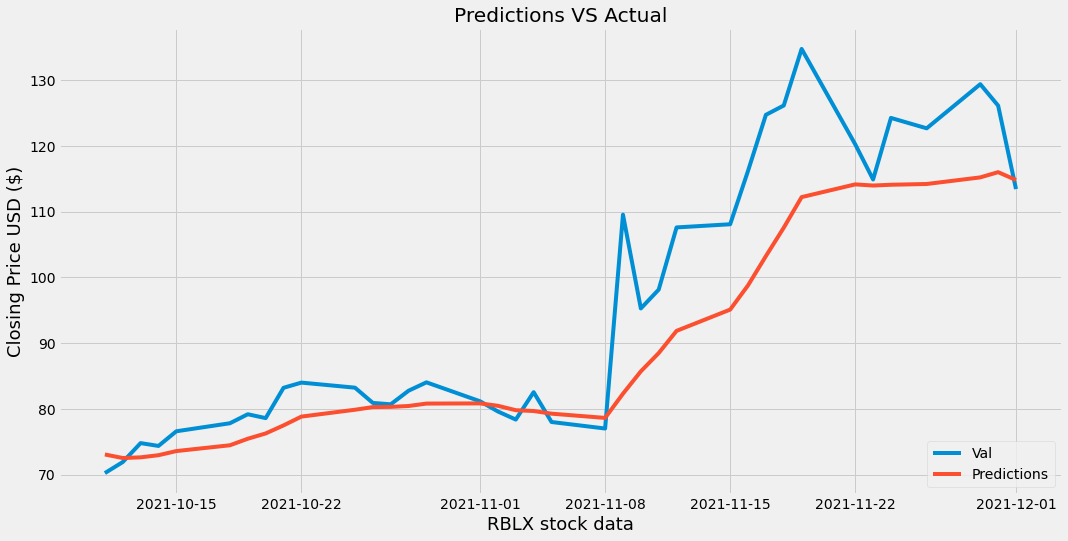

In [268]:
# Plot data
train = data_target[:training_data_len]
valid = data_target[training_data_len:]
valid['Predictions'] = predictions

# Visualize data
plt.figure(figsize=(16,8))
plt.title('Predictions VS Actual')
plt.xlabel(stock + ' stock data', fontsize=18)
plt.ylabel('Closing Price USD ($)', fontsize=18)
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Val', 'Predictions'], loc='lower right')
plt.show()

In [269]:
# Show all valid and predicted prices
valid

,Close,Predictions
Date,,
2021-10-11,70.220001,73.050743
2021-10-12,71.900002,72.512787
2021-10-13,74.779999,72.614655
2021-10-14,74.349998,72.940666
2021-10-15,76.580002,73.568832
2021-10-18,77.800003,74.450958
2021-10-19,79.169998,75.445213
2021-10-20,78.580002,76.249664
2021-10-21,83.190002,77.472519


In [270]:
def uniquify(path):
    filename, extension = os.path.splitext(path)
    counter = 1

    while os.path.exists(path):
        path = filename + "_" + str(counter) + extension
        counter += 1

    return path

In [271]:
# Saving Keras model
path = model.save(uniquify(f'{stock}_lstm_model'))

INFO:tensorflow:Assets written to: RBLX_lstm_model/assets


INFO:tensorflow:Assets written to: RBLX_lstm_model/assets


In [272]:
# Save predictions to database
#conn = None
#cursor = None
#cwd = os.getcwd()
#results = pd.DataFrame(data=valid)
#data_dir = os.path.join(cwd, 'data')
#if not os.path.exists(data_dir):
#    os.mkdir(data_dir)
#if conn is None:
#    os.chdir(data_dir)
#    conn = sqlite3.connect('predictions.db')
#cursor = conn.cursor()
#os.chdir(cwd)
#df.to_sql(results, conn, if_exists='replace')

/home/hjalmar/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:2779: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  sql.to_sql(


UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('<U32'), dtype('<U32')) -> dtype('<U32')